In [11]:
import numpy as np
import pandas as pd
from scipy import stats
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import local_pkg_path
import counterfactual_evaluation as cfeval

In [308]:
matplotlib.rcParams['pdf.fonttype'] = 42

Total number of queries for each fold

In [4]:
folds = ['Fold1', 'Fold2', 'Fold3']

num_queries = []

for fold in folds:
    sim_exp_train_vali_rankings = pd.read_csv(f'../build/simulation/{fold}/sim_exp_train_vali_rankings.csv')
    nqids = sim_exp_train_vali_rankings['qid'].nunique()
    num_queries.append(nqids)

Click models

In [7]:
examination_nf = 10
eta = 1
noise_eps = dict([(0, 0.1), (1, 1.0)])
noise_model = cfeval.simulator.ClickNoise(noise_eps)
examination_model = cfeval.simulator.ContextualPositionExamination(eta, examination_nf)
click_model = cfeval.simulator.PositionBasedClickModel(examination_model, noise_model)

Model weights

In [8]:
weights_folds = []

for fold in folds:
    with open(f'../build/simulation/{fold}/examination_weights.pkl', 'rb') as f:
        weights = pickle.load(f)
    weights_folds.append(weights)

Examination features

In [13]:
examination_fc_folds = []

for fold in folds:
    with open(f'../build/simulation/{fold}/examination_fc_names.pkl', 'rb') as f:
        examination_fc = pickle.load(f)
    examination_fc_folds.append(examination_fc)

In [14]:
examination_fc_folds

[array(['13', '38', '53', '54', '63', '64', '88', '126', '129', '133'],
       dtype='<U3'),
 array(['13', '38', '63', '64', '95', '107', '108', '126', '129', '133'],
       dtype='<U3'),
 array(['13', '38', '53', '63', '64', '88', '107', '126', '129', '133'],
       dtype='<U3')]

In [70]:
def load_hte_ltr_input(fold, total_nqueries, nq, avg_clicks):
    print('Reading random swapping and LTR clicks')
    ltr_clicks = pd.read_csv(
        f'../build/simulation/{fold}/sim_exp_ltr_train_vali_clicks_avg_clicks_{avg_clicks}.csv')
    swap_clicks = pd.read_csv(
        f'../build/simulation/{fold}/sim_exp_swap_train_vali_clicks_avg_clicks_{avg_clicks}.csv')
    print('Loading swapping query ids')
    with open(f'../build/simulation/{fold}/sim_exp_swap_query_ids_{nq}.pkl', 'rb') as f:
        swap_qids = pickle.load(f)
    with open(f'../build/simulation/{fold}/sim_exp_swap_query_ids_{total_nqueries}.pkl', 'rb') as f:
        total_qids = pickle.load(f)
    ltr_qids = np.setdiff1d(total_qids, swap_qids)
    print('Merging swapping and LTR clicks')
    exp_clicks = pd.concat([swap_clicks[swap_clicks['qid'].isin(swap_qids)],
                            ltr_clicks[ltr_clicks['qid'].isin(ltr_qids)]])
    exp_clicks = exp_clicks.sort_values(['list_id', 'swapped_rank'])
    exp_clicks = exp_clicks.rename(columns={'swapped_rank': 'exam_position'})
    exp_clicks['exam_position'] = exp_clicks['exam_position'].astype(int)
    return exp_clicks

In [71]:
def compute_true_quantities(data, click_model, examination_fc):
    nrows = data.shape[0]
    # true click probability at 1
    data['true_click_prob@1'] = click_model.probabilities(
        np.ones(nrows), data['y'].values, data[examination_fc].values)
    # true tau
    data['true_tau'] = data['true_click_prob@1'] - data['true_click_probability']
    return data

In [72]:
def merge_hte_estimations_and_true_values(data, fold, avg_clicks, nq, examination_fc, click_model):
    for algo in ['causal_forests', 'xlearner']:
        hte_estimations = pd.read_csv(
            f'../build/simulation/{fold}/sim_exp_swap_{algo}_ltr_test_results_{avg_clicks}_{nq}.csv')
        curr_hte_estimations = hte_estimations[
            ['partition', 'qd_id', 'treatment_rank', 'tau_pred']].rename(
            columns={'treatment_rank': 'exam_position'})
        curr_hte_estimations['exam_position'] = (
                curr_hte_estimations['exam_position'] + 1)
        data = data.merge(curr_hte_estimations, how='left',
                          on=['partition', 'qd_id', 'exam_position'])
        data['tau_pred'] = data['tau_pred'].fillna(0.0)
        data = data.rename(columns={'tau_pred': f'{algo}_tau_pred'})
    examination_features = hte_estimations[['partition', 'qd_id', *examination_fc]]
    data = data.merge(examination_features, how='left', on=['partition', 'qd_id'])
    data = compute_true_quantities(data, click_model, examination_fc)
    data = data.drop(examination_fc, axis=1)
    return data

In [ ]:
theta_results = []
for i, fold in enumerate(folds):
    total_nqueries = num_queries[i]
    examination_fc = examination_fc_folds[i]
    click_model.examination.weights = weights_folds[i]
    for avg_clicks in [5, 10, 25, 50]:
        for nq in [total_nqueries // j for j in [100, 10, 2, 1]]:
            data = load_hte_ltr_input(fold, total_nqueries, nq, avg_clicks)
            data = merge_hte_estimations_and_true_values(data, fold, avg_clicks, nq, examination_fc, click_model)
            observed_impression = (data.groupby(
                ['partition', 'qd_id', 'exam_position'])['click'].mean()
                                   .rename('observed_ctr').reset_index())
            data = data.merge(observed_impression, how='left',
                              on=['partition', 'qd_id', 'exam_position'])
            for algo in ['causal_forests', 'xlearner']:
                data[f'{algo}_corrected_ctr'] = data['observed_ctr'] + data[f'{algo}_tau_pred']
                data.loc[data[f'{algo}_corrected_ctr'] > 1, f'{algo}_corrected_ctr'] = 1
                data.loc[data[f'{algo}_corrected_ctr'] < 0, f'{algo}_corrected_ctr'] = 0
            data['avg_clicks'] = avg_clicks
            data['nqueries'] = nq
            data['fold'] = fold
            theta_results.append(data)
theta_results = pd.concat(theta_results)

In [117]:
del data

In [111]:
for theta_res in theta_results:
    for algo in ['causal_forests', 'xlearner']:
        theta_res[f'{algo}_theta'] = theta_res[f'{algo}_corrected_ctr']
        theta_res.loc[theta_res[f'{algo}_corrected_ctr'] > 1, f'{algo}_theta'] = 1
        theta_res.loc[theta_res[f'{algo}_corrected_ctr'] < 0, f'{algo}_theta'] = 0

In [112]:
len(theta_results)

48

In [116]:
theta_results[45].columns

Index(['qid', 'list_id', 'partition', 'y', 'qd_id', 'pred_rank', 'pred_score',
       'exam_position', 'click', 'true_click_probability', 'true_propensity',
       'inverse_true_propensity', 'causal_forests_tau_pred',
       'xlearner_tau_pred', 'true_click_prob@1', 'true_tau', 'observed_ctr',
       'causal_forests_corrected_ctr', 'theta', 'xlearner_corrected_ctr',
       'avg_clicks', 'nqueries', 'fold', 'causal_forests_theta',
       'xlearner_theta'],
      dtype='object')

In [132]:
deduplicates = []
for i in range(48):
    res = theta_results.pop()
    res = res.drop_duplicates(subset=['partition', 'qd_id', 'y', 'exam_position'])
    deduplicates.append(res)

In [134]:
del theta_results

In [136]:
deduplicates = pd.concat(deduplicates)

In [120]:
stats_col = ['partition', 'qd_id', 'y', 'exam_position', 
             'true_click_probability', 'observed_ctr', 'causal_forests_corrected_ctr', 'xlearner_corrected_ctr',
             'true_click_prob@1', 'true_propensity', 'true_tau', 'causal_forests_tau_pred', 'xlearner_tau_pred']

In [137]:
nqueries_to_percentange = dict()
for i, fold in enumerate(folds):
    total_nqueries = num_queries[i]
    num_to_p = zip([total_nqueries // j for j in [100, 10, 2, 1]], ['1%', '10%', '50%', '100%'])
    nqueries_to_percentange.update(num_to_p)
nqueries_to_percentange

{158: '1%',
 1589: '10%',
 7948: '50%',
 15896: '100%',
 159: '1%',
 1596: '10%',
 7983: '50%',
 15966: '100%',
 1599: '10%',
 7996: '50%',
 15992: '100%'}

In [138]:
deduplicates.head()

,qid,list_id,partition,y,qd_id,pred_rank,pred_score,exam_position,click,true_click_probability,...,true_tau,observed_ctr,causal_forests_corrected_ctr,theta,xlearner_corrected_ctr,avg_clicks,nqueries,fold,causal_forests_theta,xlearner_theta
0,6867,1,train,0,68645,4.0,202.390381,1,0,0.100000,...,0.000000,0.500000,0.500000,NaN,0.500000,50,15992,Fold3,0.500000,0.500000
9,6867,1,train,0,68647,2.0,8999.341797,2,0,0.022260,...,0.077740,0.030303,0.078001,NaN,0.070286,50,15992,Fold3,0.078001,0.070286
18,6867,1,train,0,68644,3.0,206.878586,3,0,0.030911,...,0.069089,0.029412,0.097842,NaN,0.078333,50,15992,Fold3,0.097842,0.078333
27,6867,1,train,0,68648,1.0,9094.413086,4,0,0.000063,...,0.099937,0.000000,0.151772,NaN,0.135913,50,15992,Fold3,0.151772,0.135913
36,6867,1,train,0,68646,5.0,189.890549,5,0,0.100000,...,0.000000,0.083333,0.118319,NaN,0.011141,50,15992,Fold3,0.118319,0.011141


In [139]:
deduplicates.columns

Index(['qid', 'list_id', 'partition', 'y', 'qd_id', 'pred_rank', 'pred_score',
       'exam_position', 'click', 'true_click_probability', 'true_propensity',
       'inverse_true_propensity', 'causal_forests_tau_pred',
       'xlearner_tau_pred', 'true_click_prob@1', 'true_tau', 'observed_ctr',
       'causal_forests_corrected_ctr', 'theta', 'xlearner_corrected_ctr',
       'avg_clicks', 'nqueries', 'fold', 'causal_forests_theta',
       'xlearner_theta'],
      dtype='object')

In [140]:
deduplicates['Percentage of Training Queries'] = deduplicates['nqueries'].map(nqueries_to_percentange.get)
deduplicates = deduplicates.rename(columns={'avg_clicks': 'Avg. Searches/Query'})

In [141]:
deduplicates = deduplicates.rename(columns={'true_click_probability': 'True Model CTR', 
                                            'observed_ctr': 'Observation CTR', 
                                            'causal_forests_corrected_ctr': 'Causal Forests Theta',
                                            'xlearner_corrected_ctr': 'X-Learner Theta'})

In [142]:
deduplicates.head()

,qid,list_id,partition,y,qd_id,pred_rank,pred_score,exam_position,click,True Model CTR,...,Observation CTR,Causal Forests Theta,theta,X-Learner Theta,Avg. Searches/Query,nqueries,fold,causal_forests_theta,xlearner_theta,Percentage of Training Queries
0,6867,1,train,0,68645,4.0,202.390381,1,0,0.100000,...,0.500000,0.500000,NaN,0.500000,50,15992,Fold3,0.500000,0.500000,100%
9,6867,1,train,0,68647,2.0,8999.341797,2,0,0.022260,...,0.030303,0.078001,NaN,0.070286,50,15992,Fold3,0.078001,0.070286,100%
18,6867,1,train,0,68644,3.0,206.878586,3,0,0.030911,...,0.029412,0.097842,NaN,0.078333,50,15992,Fold3,0.097842,0.078333,100%
27,6867,1,train,0,68648,1.0,9094.413086,4,0,0.000063,...,0.000000,0.151772,NaN,0.135913,50,15992,Fold3,0.151772,0.135913,100%
36,6867,1,train,0,68646,5.0,189.890549,5,0,0.100000,...,0.083333,0.118319,NaN,0.011141,50,15992,Fold3,0.118319,0.011141,100%


In [150]:
deduplicates = deduplicates.rename(columns={'causal_forests_theta': 'Causal Forests Theta Truncated',
                                            'xlearner_theta': 'X-Learner Theta Truncated'})

In [151]:
plot_results = deduplicates.melt(
    id_vars=['fold', 'Avg. Searches/Query', 'Percentage of Training Queries', 'partition', 'qd_id', 'y', 'exam_position'],
    value_vars=['True Model CTR', 'Observation CTR', 'Causal Forests Theta Truncated', 'X-Learner Theta Truncated'],
    var_name='Type', value_name='Model and Prediction Theta')

In [152]:
plot_results['Percentage of Training Queries'] = pd.Categorical(plot_results['Percentage of Training Queries'].values, categories=['1%', '10%', '50%', '100%'])

All data

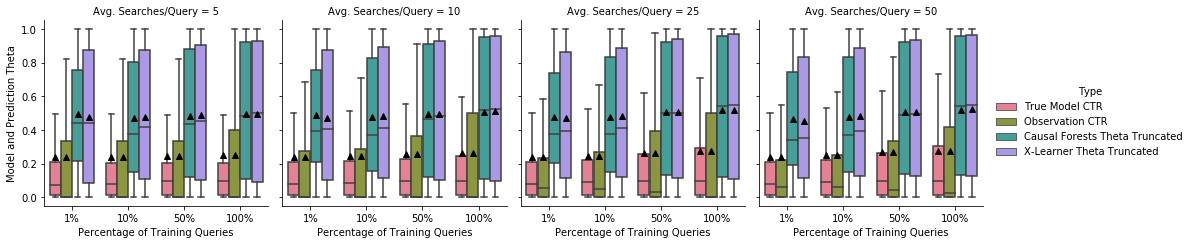

In [156]:
g = sns.catplot('Percentage of Training Queries', 'Model and Prediction Theta', 'Type', data=plot_results, 
                col='Avg. Searches/Query', 
                kind='box', palette='husl', hue_order=['True Model CTR', 'Observation CTR', 'Causal Forests Theta Truncated', 'X-Learner Theta Truncated'],
                order=['1%', '10%', '50%', '100%'],
                showmeans=True, showfliers=False,
                meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k'}, height=3.5)

Positive Examples

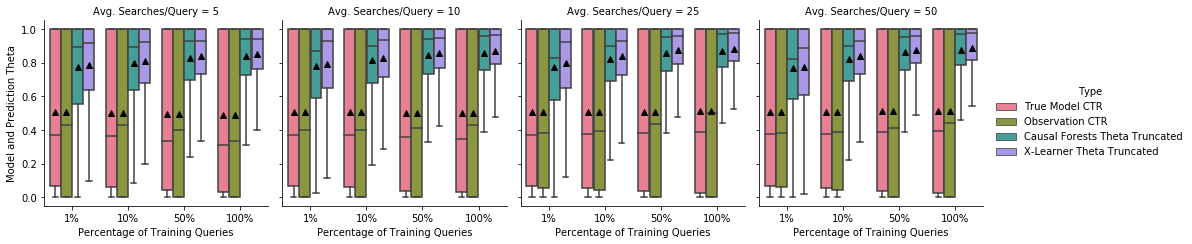

In [157]:
g = sns.catplot('Percentage of Training Queries', 'Model and Prediction Theta', 'Type', data=plot_results[plot_results['y'] > 0], 
                col='Avg. Searches/Query', 
                kind='box', palette='husl', hue_order=['True Model CTR', 'Observation CTR', 'Causal Forests Theta Truncated', 'X-Learner Theta Truncated'],
                order=['1%', '10%', '50%', '100%'],
                showmeans=True, showfliers=False,
                meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k'}, height=3.5)

Negative Examples

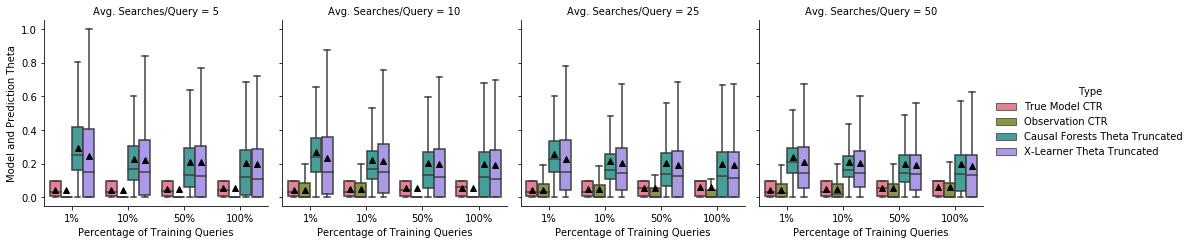

In [158]:
g = sns.catplot('Percentage of Training Queries', 'Model and Prediction Theta', 'Type', data=plot_results[plot_results['y'] == 0], 
                col='Avg. Searches/Query', 
                kind='box', palette='husl', hue_order=['True Model CTR', 'Observation CTR', 'Causal Forests Theta Truncated', 'X-Learner Theta Truncated'],
                order=['1%', '10%', '50%', '100%'],
                showmeans=True, showfliers=False,
                meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k'}, height=3.5)

Without truncation

In [159]:
plot_results = deduplicates.melt(
    id_vars=['fold', 'Avg. Searches/Query', 'Percentage of Training Queries', 'partition', 'qd_id', 'y', 'exam_position'],
    value_vars=['True Model CTR', 'Observation CTR', 'Causal Forests Theta', 'X-Learner Theta'],
    var_name='Type', value_name='Model and Prediction Theta')

In [160]:
plot_results['Percentage of Training Queries'] = pd.Categorical(plot_results['Percentage of Training Queries'].values, categories=['1%', '10%', '50%', '100%'])

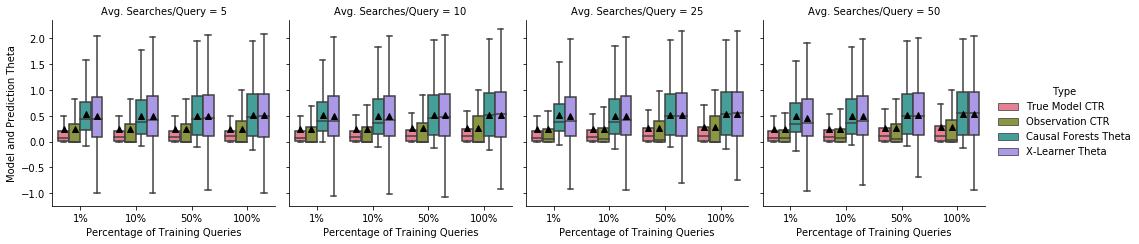

In [161]:
g = sns.catplot('Percentage of Training Queries', 'Model and Prediction Theta', 'Type', data=plot_results, 
                col='Avg. Searches/Query', 
                kind='box', palette='husl', hue_order=['True Model CTR', 'Observation CTR', 'Causal Forests Theta', 'X-Learner Theta'],
                order=['1%', '10%', '50%', '100%'],
                showmeans=True, showfliers=False,
                meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k'}, height=3.5)

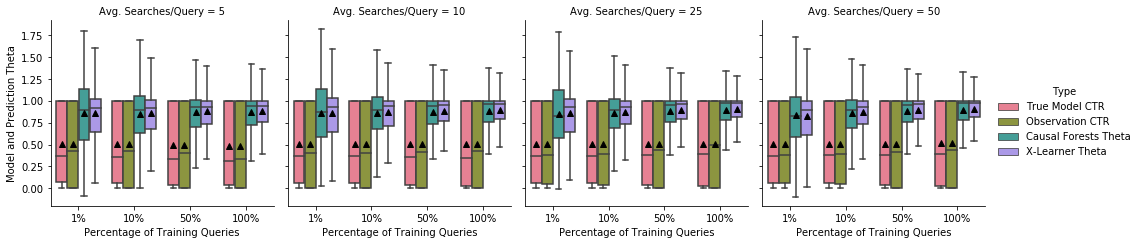

In [162]:
g = sns.catplot('Percentage of Training Queries', 'Model and Prediction Theta', 'Type', data=plot_results[plot_results['y'] > 0], 
                col='Avg. Searches/Query', 
                kind='box', palette='husl', hue_order=['True Model CTR', 'Observation CTR', 'Causal Forests Theta', 'X-Learner Theta'],
                order=['1%', '10%', '50%', '100%'],
                showmeans=True, showfliers=False,
                meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k'}, height=3.5)

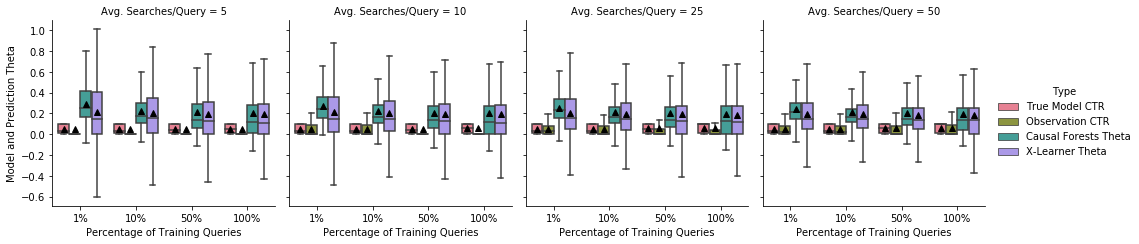

In [163]:
g = sns.catplot('Percentage of Training Queries', 'Model and Prediction Theta', 'Type', data=plot_results[plot_results['y'] == 0], 
                col='Avg. Searches/Query', 
                kind='box', palette='husl', hue_order=['True Model CTR', 'Observation CTR', 'Causal Forests Theta', 'X-Learner Theta'],
                order=['1%', '10%', '50%', '100%'],
                showmeans=True, showfliers=False,
                meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k'}, height=3.5)

CPBM data

In [165]:
deduplicates.head()

,qid,list_id,partition,y,qd_id,pred_rank,pred_score,exam_position,click,True Model CTR,...,Observation CTR,Causal Forests Theta,theta,X-Learner Theta,Avg. Searches/Query,nqueries,fold,Causal Forests Theta Truncated,X-Learner Theta Truncated,Percentage of Training Queries
0,6867,1,train,0,68645,4.0,202.390381,1,0,0.100000,...,0.500000,0.500000,NaN,0.500000,50,15992,Fold3,0.500000,0.500000,100%
9,6867,1,train,0,68647,2.0,8999.341797,2,0,0.022260,...,0.030303,0.078001,NaN,0.070286,50,15992,Fold3,0.078001,0.070286,100%
18,6867,1,train,0,68644,3.0,206.878586,3,0,0.030911,...,0.029412,0.097842,NaN,0.078333,50,15992,Fold3,0.097842,0.078333,100%
27,6867,1,train,0,68648,1.0,9094.413086,4,0,0.000063,...,0.000000,0.151772,NaN,0.135913,50,15992,Fold3,0.151772,0.135913,100%
36,6867,1,train,0,68646,5.0,189.890549,5,0,0.100000,...,0.083333,0.118319,NaN,0.011141,50,15992,Fold3,0.118319,0.011141,100%


In [167]:
deduplicates = deduplicates.drop('theta', axis=1)

In [168]:
deduplicates.head()

,qid,list_id,partition,y,qd_id,pred_rank,pred_score,exam_position,click,True Model CTR,...,true_tau,Observation CTR,Causal Forests Theta,X-Learner Theta,Avg. Searches/Query,nqueries,fold,Causal Forests Theta Truncated,X-Learner Theta Truncated,Percentage of Training Queries
0,6867,1,train,0,68645,4.0,202.390381,1,0,0.100000,...,0.000000,0.500000,0.500000,0.500000,50,15992,Fold3,0.500000,0.500000,100%
9,6867,1,train,0,68647,2.0,8999.341797,2,0,0.022260,...,0.077740,0.030303,0.078001,0.070286,50,15992,Fold3,0.078001,0.070286,100%
18,6867,1,train,0,68644,3.0,206.878586,3,0,0.030911,...,0.069089,0.029412,0.097842,0.078333,50,15992,Fold3,0.097842,0.078333,100%
27,6867,1,train,0,68648,1.0,9094.413086,4,0,0.000063,...,0.099937,0.000000,0.151772,0.135913,50,15992,Fold3,0.151772,0.135913,100%
36,6867,1,train,0,68646,5.0,189.890549,5,0,0.100000,...,0.000000,0.083333,0.118319,0.011141,50,15992,Fold3,0.118319,0.011141,100%


In [169]:
deduplicates.columns

Index(['qid', 'list_id', 'partition', 'y', 'qd_id', 'pred_rank', 'pred_score',
       'exam_position', 'click', 'True Model CTR', 'true_propensity',
       'inverse_true_propensity', 'causal_forests_tau_pred',
       'xlearner_tau_pred', 'true_click_prob@1', 'true_tau', 'Observation CTR',
       'Causal Forests Theta', 'X-Learner Theta', 'Avg. Searches/Query',
       'nqueries', 'fold', 'Causal Forests Theta Truncated',
       'X-Learner Theta Truncated', 'Percentage of Training Queries'],
      dtype='object')

In [177]:
cpbm_ltr = []
for fold in folds:
    cpbm_estimations = pd.read_csv(
        f'../build/simulation/{fold}/sim_exp_swap_cpbm_ips_ltr_test_results.csv')
    cpbm_estimations['fold'] = fold
    cpbm_ltr.append(cpbm_estimations)
cpbm_ltr = pd.concat(cpbm_ltr)

In [178]:
cpbm_ltr['inverse_cpbm_propensity_ratio_hat'].max()

33554432.0

In [179]:
cpbm_ltr.head()

,partition,qd_id,exam_position,cpbm_propensity_ratio_hat,avg_clicks,nqueries,inverse_cpbm_propensity_ratio_hat,fold
0,train,0,2,0.022221,5,158,45.003197,Fold1
1,train,1,2,0.013393,5,158,74.663370,Fold1
2,train,2,2,0.082247,5,158,12.158533,Fold1
3,train,3,2,0.737217,5,158,1.356453,Fold1
4,train,4,2,0.036747,5,158,27.213163,Fold1


In [181]:
cpbm_ltr = cpbm_ltr.rename(columns={'avg_clicks': 'Avg. Searches/Query'})

In [180]:
deduplicates.head()

,qid,list_id,partition,y,qd_id,pred_rank,pred_score,exam_position,click,True Model CTR,...,true_tau,Observation CTR,Causal Forests Theta,X-Learner Theta,Avg. Searches/Query,nqueries,fold,Causal Forests Theta Truncated,X-Learner Theta Truncated,Percentage of Training Queries
0,6867,1,train,0,68645,4.0,202.390381,1,0,0.100000,...,0.000000,0.500000,0.500000,0.500000,50,15992,Fold3,0.500000,0.500000,100%
9,6867,1,train,0,68647,2.0,8999.341797,2,0,0.022260,...,0.077740,0.030303,0.078001,0.070286,50,15992,Fold3,0.078001,0.070286,100%
18,6867,1,train,0,68644,3.0,206.878586,3,0,0.030911,...,0.069089,0.029412,0.097842,0.078333,50,15992,Fold3,0.097842,0.078333,100%
27,6867,1,train,0,68648,1.0,9094.413086,4,0,0.000063,...,0.099937,0.000000,0.151772,0.135913,50,15992,Fold3,0.151772,0.135913,100%
36,6867,1,train,0,68646,5.0,189.890549,5,0,0.100000,...,0.000000,0.083333,0.118319,0.011141,50,15992,Fold3,0.118319,0.011141,100%


In [182]:
deduplicates = deduplicates.merge(cpbm_ltr, how='left', 
                                  on=['fold', 'partition', 'qd_id', 'exam_position', 'Avg. Searches/Query', 'nqueries'])

In [183]:
deduplicates.head()

,qid,list_id,partition,y,qd_id,pred_rank,pred_score,exam_position,click,True Model CTR,...,Causal Forests Theta,X-Learner Theta,Avg. Searches/Query,nqueries,fold,Causal Forests Theta Truncated,X-Learner Theta Truncated,Percentage of Training Queries,cpbm_propensity_ratio_hat,inverse_cpbm_propensity_ratio_hat
0,6867,1,train,0,68645,4.0,202.390381,1,0,0.100000,...,0.500000,0.500000,50,15992,Fold3,0.500000,0.500000,100%,NaN,NaN
1,6867,1,train,0,68647,2.0,8999.341797,2,0,0.022260,...,0.078001,0.070286,50,15992,Fold3,0.078001,0.070286,100%,0.265723,3.763314
2,6867,1,train,0,68644,3.0,206.878586,3,0,0.030911,...,0.097842,0.078333,50,15992,Fold3,0.097842,0.078333,100%,0.367229,2.723095
3,6867,1,train,0,68648,1.0,9094.413086,4,0,0.000063,...,0.151772,0.135913,50,15992,Fold3,0.151772,0.135913,100%,0.006719,148.838870
4,6867,1,train,0,68646,5.0,189.890549,5,0,0.100000,...,0.118319,0.011141,50,15992,Fold3,0.118319,0.011141,100%,0.977677,1.022832


In [184]:
deduplicates = deduplicates.fillna(1.0)

In [185]:
deduplicates['CPBM IPS Weighted Observation CTR'] = deduplicates['Observation CTR'] * deduplicates['inverse_cpbm_propensity_ratio_hat']

In [186]:
deduplicates = deduplicates.rename(columns={'y': 'R'})

In [209]:
deduplicates.head()

,qid,list_id,partition,R,qd_id,pred_rank,pred_score,exam_position,click,True Model CTR,...,X-Learner Theta,Avg. Searches/Query,nqueries,fold,Causal Forests Theta Truncated,X-Learner Theta Truncated,Percentage of Training Queries,cpbm_propensity_ratio_hat,inverse_cpbm_propensity_ratio_hat,CPBM IPS Weighted Observation CTR
0,6867,1,train,0,68645,4.0,202.390381,1,0,0.100000,...,0.500000,50,15992,Fold3,0.500000,0.500000,100%,1.000000,1.000000,0.500000
1,6867,1,train,0,68647,2.0,8999.341797,2,0,0.022260,...,0.070286,50,15992,Fold3,0.078001,0.070286,100%,0.265723,3.763314,0.114040
2,6867,1,train,0,68644,3.0,206.878586,3,0,0.030911,...,0.078333,50,15992,Fold3,0.097842,0.078333,100%,0.367229,2.723095,0.080091
3,6867,1,train,0,68648,1.0,9094.413086,4,0,0.000063,...,0.135913,50,15992,Fold3,0.151772,0.135913,100%,0.006719,148.838870,0.000000
4,6867,1,train,0,68646,5.0,189.890549,5,0,0.100000,...,0.011141,50,15992,Fold3,0.118319,0.011141,100%,0.977677,1.022832,0.085236


In [210]:
deduplicates.to_csv('../build/simulation/ctr_results_data.csv', index=False)

In [285]:
from itertools import cycle

hatches = cycle(['xx', '', '//', '..', '\\\\'])

def add_hatches(x, y, **kwargs):
    ax = plt.gca()
    hs, l = ax.get_legend_handles_labels()
    for h in hs:
        hatch = next(hatches)
        h.set_hatch(hatch)
    for i, box in enumerate(ax.artists):
        hatch = next(hatches)
        box.set_hatch(hatch)
    ax.set_xlabel(x.name)
    ax.set_ylabel(y.name)
#     ax.set_yscale('log')

Overall

In [321]:
plot_results = deduplicates.melt(
    id_vars=['fold', 'Avg. Searches/Query', 'Percentage of Training Queries', 'partition', 'qd_id', 'R', 'exam_position'],
    value_vars=['True Model CTR', 'Observation CTR', 'Causal Forests Theta Truncated', 'X-Learner Theta Truncated', 'CPBM IPS Weighted Observation CTR'],
    var_name='Type', value_name='CTR')

Boxplot with mean

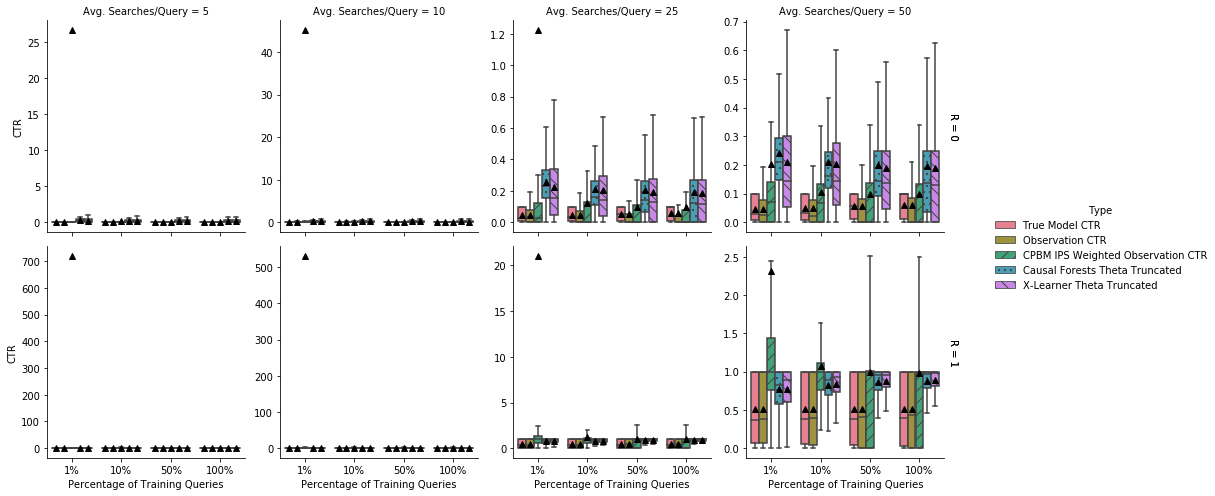

In [224]:
g = sns.catplot(x='Percentage of Training Queries', y='CTR', hue='Type', data=plot_results, 
                col='Avg. Searches/Query', row='R',
                kind='box', palette='husl', 
                hue_order=['True Model CTR', 'Observation CTR', 'CPBM IPS Weighted Observation CTR', 'Causal Forests Theta Truncated', 'X-Learner Theta Truncated'],
                order=['1%', '10%', '50%', '100%'],
                showmeans=True, showfliers=False,
                sharey=False, margin_titles=True,
                meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k'}, height=3.5, legend=False)
g = g.map(add_hatches, 'Percentage of Training Queries', 'CTR')
g.add_legend(title='Type')

In [277]:
sample_plot = plot_results.sample(1000)

Log scale

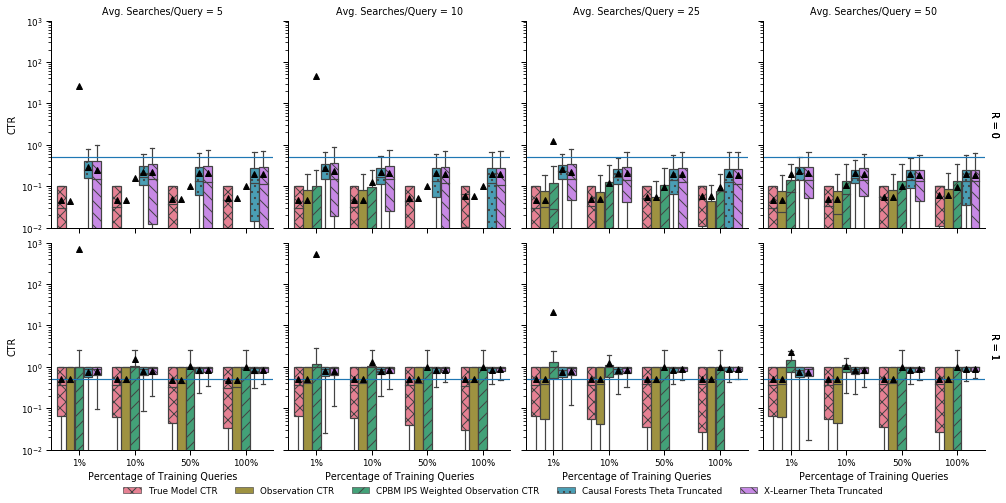

In [313]:
with sns.plotting_context('paper', 1):
    g = sns.catplot(x='Percentage of Training Queries', y='CTR', hue='Type', data=plot_results, 
                    col='Avg. Searches/Query', row='R',
                    kind='box', palette='husl', 
                    hue_order=['True Model CTR', 'Observation CTR', 'CPBM IPS Weighted Observation CTR', 'Causal Forests Theta Truncated', 'X-Learner Theta Truncated'],
                    order=['1%', '10%', '50%', '100%'],
                    showmeans=True, showfliers=False,
                    margin_titles=True,
                    meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k'}, height=3.5, legend=False)
    g = g.map(plt.axhline, y=0.5)
    g = g.map(add_hatches, 'Percentage of Training Queries', 'CTR')
    plt.yscale('log')
    plt.ylim(0.01, 1000)
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=5, frameon=False)
    g.fig.subplots_adjust(bottom=0.1)

In [314]:
g.savefig('../build/simulation/figures/result-ctr-distribution-h3.5.pdf')

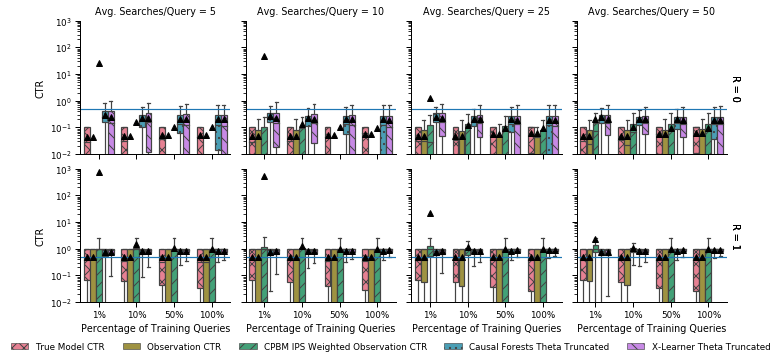

In [328]:
with sns.plotting_context('paper', 1):
    g = sns.catplot(x='Percentage of Training Queries', y='CTR', hue='Type', data=plot_results, 
                    col='Avg. Searches/Query', row='R',
                    kind='box', palette='husl', 
                    hue_order=['True Model CTR', 'Observation CTR', 'CPBM IPS Weighted Observation CTR', 'Causal Forests Theta Truncated', 'X-Learner Theta Truncated'],
                    order=['1%', '10%', '50%', '100%'],
                    showmeans=True, showfliers=False,
                    margin_titles=True,
                    meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k'}, height=2.5, aspect=1,legend=False)
    g = g.map(plt.axhline, y=0.5)
    g = g.map(add_hatches, 'Percentage of Training Queries', 'CTR')
    plt.yscale('log')
    plt.ylim(0.01, 1000)
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=5, frameon=False)
    g.fig.subplots_adjust(bottom=0.15)

In [329]:
g.savefig('../build/simulation/figures/result-ctr-distribution-h2.5.pdf')

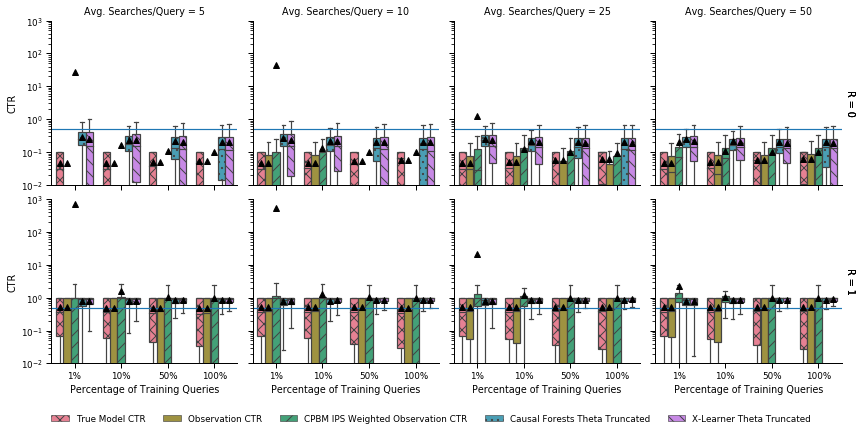

In [325]:
with sns.plotting_context('paper', 1):
    g = sns.catplot(x='Percentage of Training Queries', y='CTR', hue='Type', data=plot_results, 
                    col='Avg. Searches/Query', row='R',
                    kind='box', palette='husl', 
                    hue_order=['True Model CTR', 'Observation CTR', 'CPBM IPS Weighted Observation CTR', 'Causal Forests Theta Truncated', 'X-Learner Theta Truncated'],
                    order=['1%', '10%', '50%', '100%'],
                    showmeans=True, showfliers=False,
                    margin_titles=True,
                    meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k'}, height=3, legend=False)
    g = g.map(plt.axhline, y=0.5)
    g = g.map(add_hatches, 'Percentage of Training Queries', 'CTR')
    plt.yscale('log')
    plt.ylim(0.01, 1000)
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=5, frameon=False)
    g.fig.subplots_adjust(bottom=0.15)

In [326]:
g.savefig('../build/simulation/figures/result-ctr-distribution.pdf')

Boxplot without mean

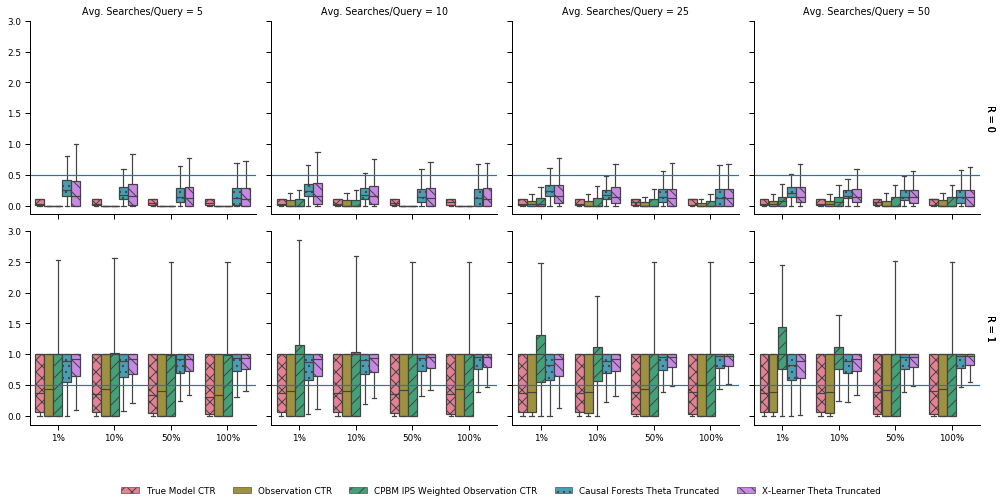

In [289]:
with sns.plotting_context('paper', 1):
    g = sns.catplot(x='Percentage of Training Queries', y='CTR', hue='Type', data=plot_results, 
                    col='Avg. Searches/Query', row='R',
                    kind='box', palette='husl', 
                    hue_order=['True Model CTR', 'Observation CTR', 'CPBM IPS Weighted Observation CTR', 'Causal Forests Theta Truncated', 'X-Learner Theta Truncated'],
                    order=['1%', '10%', '50%', '100%'],
                    showmeans=False, showfliers=False,
                    sharey=True, margin_titles=True,
                    meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k'}, height=3.5, legend=False)
    g = g.map(plt.axhline, y=0.5)
    g = g.map(add_hatches, 'Percentage of Training Queries', 'CTR')
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=5, frameon=False)
    g.fig.subplots_adjust(bottom=0.15)

False Positive

In [330]:
plot_results_obs_false_pos = deduplicates[(deduplicates['Observation CTR'] > 0) & (deduplicates['R'] == 0)]

In [331]:
plot_results = plot_results_obs_false_pos.melt(
    id_vars=['fold', 'Avg. Searches/Query', 'Percentage of Training Queries', 'partition', 'qd_id', 'R', 'exam_position'],
    value_vars=['True Model CTR', 'Observation CTR', 'Causal Forests Theta Truncated', 'X-Learner Theta Truncated', 'CPBM IPS Weighted Observation CTR'],
    var_name='Type', value_name='CTR')

In [317]:
plot_results[plot_results['Type'] == 'CPBM IPS Weighted Observation CTR'].groupby(
    ['Avg. Searches/Query', 'Percentage of Training Queries', 'R'])['CTR'].describe()

count        mean  \
Avg. Searches/Query Percentage of Training Queries R                         
5                   1%                             0   51448.0  142.135974   
                    10%                            0   51692.0    0.887993   
                    100%                           0   55752.0    0.773044   
                    50%                            0   53702.0    0.682355   
10                  1%                             0   86901.0  144.294554   
                    10%                            0   88192.0    0.439904   
                    100%                           0  100258.0    0.529805   
                    50%                            0   93694.0    0.434983   
25                  1%                             0  143697.0    2.374555   
                    10%                            0  147934.0    0.261569   
                    100%                           0  190059.0    0.329459   
                    50%                            0  166266.0    0.278364   
50                  1%                             0  180940.0    0.312896   
                    10%                            0  189892.0    0.178732   
                    100%                           0  281943.0    0.242031   
                    50%                            0  230924.0    0.208642   

                                                               std       min  \
Avg. Searches/Query Percentage of Training Queries R                           
5                   1%                             0   2986.595061  0.000001   
                    10%                            0      5.474190  0.064994   
                    100%                           0      3.862673  0.069292   
                    50%                            0      3.930933  0.063017   
10                  1%                             0  12613.769447  0.000243   
                    10%                            0      2.120107  0.041658   
                    100%                           0      1.923329  0.046410   
                    50%                            0      1.288410  0.039772   
25                  1%                             0    118.964761  0.000099   
                    10%                            0      1.413716  0.022248   
                    100%                           0      1.286781  0.025666   
                    50%                            0      1.190618  0.022431   
50                  1%                             0      2.598267  0.000454   
                    10%                            0      0.415112  0.013653   
                    100%                           0      0.857064  0.016335   
                    50%                            0      0.757640  0.014116   

                                                           25%       50%  \
Avg. Searches/Query Percentage of Training Queries R                       
5                   1%                             0  0.176829  0.277183   
                    10%                            0  0.196867  0.290101   
                    100%                           0  0.243311  0.441551   
                    50%                            0  0.200000  0.333333   
10                  1%                             0  0.111111  0.176640   
                    10%                            0  0.121243  0.192476   
                    100%                           0  0.160564  0.299903   
                    50%                            0  0.134990  0.230802   
25                  1%                             0  0.070025  0.118018   
                    10%                            0  0.085460  0.136883   
                    100%                           0  0.114703  0.200000   
                    50%                            0  0.098374  0.166512   
50                  1%                             0  0.075263  0.116367   
                    10%                            0  0.080000  0.11935

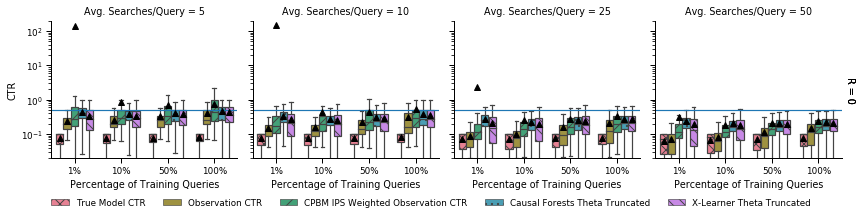

In [319]:
with sns.plotting_context('paper', 1):
    g = sns.catplot(x='Percentage of Training Queries', y='CTR', hue='Type', data=plot_results, 
                    col='Avg. Searches/Query', row='R',
                    kind='box', palette='husl', 
                    hue_order=['True Model CTR', 'Observation CTR', 'CPBM IPS Weighted Observation CTR', 'Causal Forests Theta Truncated', 'X-Learner Theta Truncated'],
                    order=['1%', '10%', '50%', '100%'],
                    showmeans=True, showfliers=False,
                    margin_titles=True,
                    meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k'}, height=3, legend=False)
    g = g.map(plt.axhline, y=0.5)
    g = g.map(add_hatches, 'Percentage of Training Queries', 'CTR')
    plt.yscale('log')
    plt.ylim(0.02, 200)
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=5, frameon=False)
    g.fig.subplots_adjust(bottom=0.25)

In [320]:
g.savefig('../build/simulation/figures/result-ctr-distribution-false-positive.pdf')

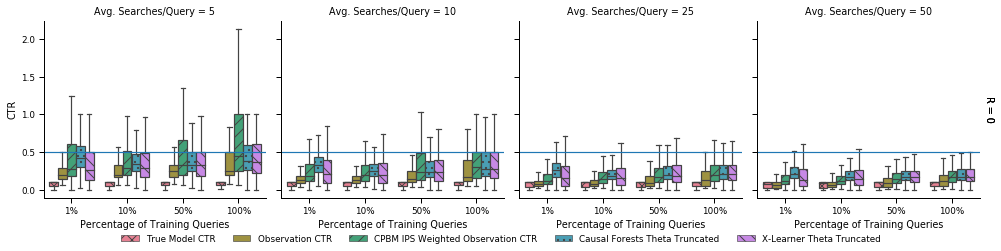

In [296]:
with sns.plotting_context('paper', 1):
    g = sns.catplot(x='Percentage of Training Queries', y='CTR', hue='Type', data=plot_results, 
                    col='Avg. Searches/Query', row='R',
                    kind='box', palette='husl', 
                    hue_order=['True Model CTR', 'Observation CTR', 'CPBM IPS Weighted Observation CTR', 'Causal Forests Theta Truncated', 'X-Learner Theta Truncated'],
                    order=['1%', '10%', '50%', '100%'],
                    showmeans=False, showfliers=False,
                    margin_titles=True,
                    meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k'}, height=3.5, legend=False)
    g = g.map(plt.axhline, y=0.5)
    g = g.map(add_hatches, 'Percentage of Training Queries', 'CTR')
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=5, frameon=False)
    g.fig.subplots_adjust(bottom=0.2)

In [297]:
g.savefig('../build/simulation/figures/result-ctr-distribution-false-positive-without-mean.pdf')

In [298]:
deduplicates[(deduplicates['Observation CTR'] > 0)]['R'].value_counts(normalize=True)

1    0.631582
0    0.368418
Name: R, dtype: float64

False negative

In [332]:
plot_results_obs_false_neg = deduplicates[(deduplicates['Observation CTR'] == 0) & (deduplicates['R'] > 0)]

In [333]:
plot_results_obs_false_neg['True Model CTR'].describe()

count    1.638683e+06
mean     4.691925e-02
std      8.476377e-02
min      2.878499e-21
25%      2.390832e-03
50%      1.319436e-02
75%      5.211883e-02
max      9.859235e-01
Name: True Model CTR, dtype: float64

In [334]:
plot_results_obs_false_neg.shape

(1638683, 28)

In [335]:
plot_results = plot_results_obs_false_neg.melt(
    id_vars=['fold', 'Avg. Searches/Query', 'Percentage of Training Queries', 'partition', 'qd_id', 'R', 'exam_position'],
    value_vars=['True Model CTR', 'Observation CTR', 'Causal Forests Theta Truncated', 'X-Learner Theta Truncated', 'CPBM IPS Weighted Observation CTR'],
    var_name='Type', value_name='CTR')

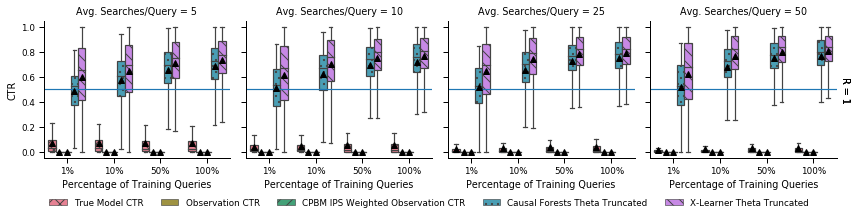

In [337]:
with sns.plotting_context('paper', 1):
    g = sns.catplot(x='Percentage of Training Queries', y='CTR', hue='Type', data=plot_results, 
                    col='Avg. Searches/Query', row='R',
                    kind='box', palette='husl', 
                    hue_order=['True Model CTR', 'Observation CTR', 'CPBM IPS Weighted Observation CTR', 'Causal Forests Theta Truncated', 'X-Learner Theta Truncated'],
                    order=['1%', '10%', '50%', '100%'],
                    showmeans=True, showfliers=False,
                    sharey=True, margin_titles=True,
                    meanprops={'markerfacecolor': 'k', 'markeredgecolor': 'k'}, height=3, aspect=0.83, legend=False)
    g = g.map(plt.axhline, y=0.5)
    g = g.map(add_hatches, 'Percentage of Training Queries', 'CTR')
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=5, frameon=False)
    g.fig.subplots_adjust(bottom=0.25)

In [338]:
g.savefig('../build/simulation/figures/result-ctr-distribution-false-negative.pdf')